In [1]:
import os
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM
from IPython.display import Audio
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
# some global variables
filepath = '/home/lagvna/slncs/'
mp3_name = 'drilling.mp3'
wav_name = 'drilling.wav'
sample_frequency = 44100
chunk_size = 44100

In [4]:
# converting mp3 to mono wav
sound = AudioSegment.from_mp3(filepath + mp3_name)
sound = sound.set_channels(1)
sound.export(filepath + wav_name, format="wav")

<_io.BufferedRandom name='/home/lagvna/slncs/drilling.wav'>

# EDA

In [5]:
rate, data = wav.read('drilling.wav')

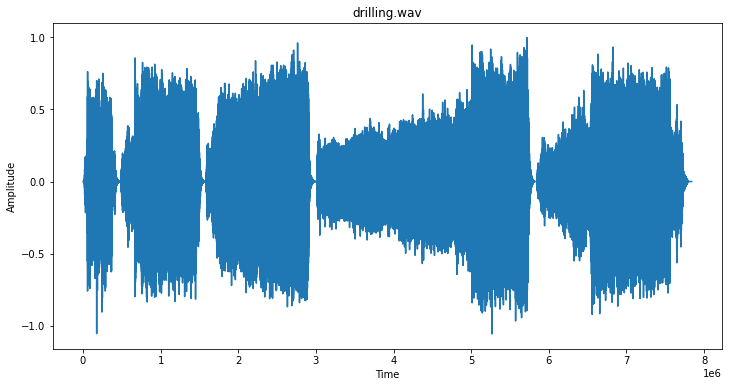

In [6]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(data/np.max(data))
plt.title(wav_name)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [7]:
len(data)/rate

177.79045351473923

/home/lagvna/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


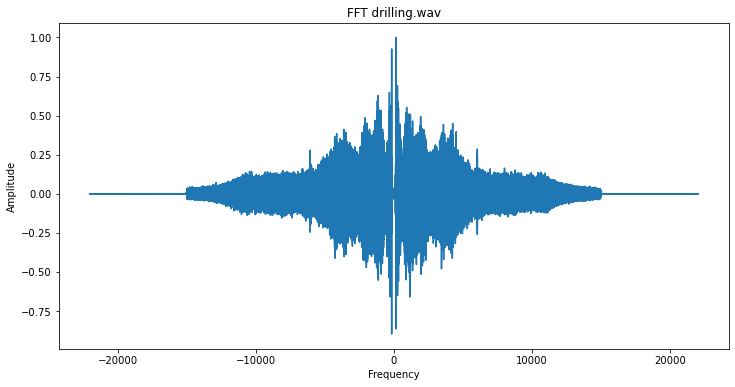

In [8]:
# fft
yf = fft(data)
yf = yf/np.max(yf)
xf = fftfreq(len(data), 1 / rate)

plt.figure(figsize=(12, 6))
plt.plot(xf, yf)
plt.title("FFT " + wav_name)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [9]:
len(data) / sample_frequency

177.79045351473923

In [10]:
# stft
f, t, Zxx = signal.stft(data, nperseg=512)

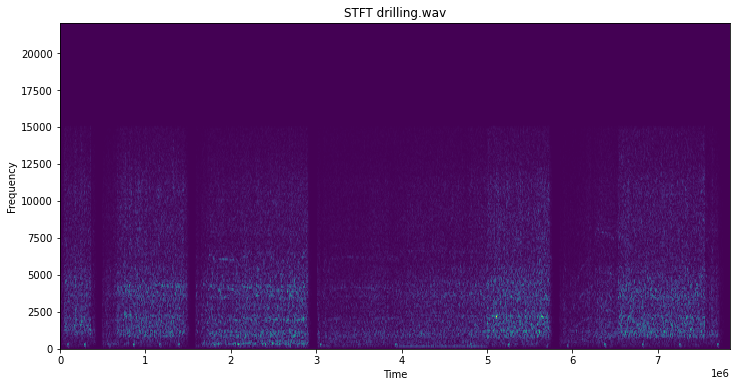

In [11]:
plt.figure(figsize=(12,6))
plt.pcolormesh(t, f*sample_frequency, np.abs(Zxx), vmin=0, shading='flat')
plt.title("STFT "+wav_name)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

# Data preprocessing

In [12]:
def divide_data(recording, chunk_size):
    remainder = len(recording) % chunk_size
    padding_size = chunk_size - remainder
    padding_vector = np.zeros(padding_size)
    padded_recording = np.append(recording, padding_vector)
    chunks = np.split(padded_recording, len(padded_recording)/chunk_size)
    
    return chunks

In [13]:
def fftransform(recording_chunks):
    fft_chunks = []
    for c in recording_chunks:
        fft_chunk = fft(c)
        full_fft_chunk = np.concatenate((np.real(fft_chunk), np.imag(fft_chunk)))
        fft_chunks.append(full_fft_chunk)
    return fft_chunks

In [14]:
def inv_fftransform(fq_chunks):
    chunks = []
    for c in fq_chunks:
        midpoint = c.shape[0] / 2
        real_chunk = c[0:int(midpoint)]
        imag_chunk = c[int(midpoint):]
        # amplitude represented as a complex number corresponding to the frequency
        full_chunk = real_chunk + 1.0j * imag_chunk
        time_chunk = ifft(full_chunk)
        chunks.append(time_chunk)
    return chunks

In [15]:
normalized_data = data / 32767.0
data_chunks = divide_data(normalized_data, chunk_size)
#print(data_chunks)
X = fftransform(data_chunks)
Y = fftransform(data_chunks[1:])
print(np.shape(X))
print(np.shape(Y))

(178, 88200)
(177, 88200)


#### LSTM requires a 3D input in the form of (samples, timesteps, features) ->
https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [16]:
timestep = 10

In [17]:
# padding with zero vectors at the end, for an equal split
while len(X)%timestep != 0:
    X.append(np.zeros(np.shape(X)[1]))
    
while len(Y)%timestep != 0:
    Y.append(np.zeros(np.shape(Y)[1]))

In [18]:
# turning into np array to split examples equally into timesteps, then going back to a list
X = np.array(X)
tmp_x = np.split(X, X.shape[0]/timestep)
x_train = np.stack(tmp_x, axis = 0)

Y = np.array(Y)
tmp_y = np.split(Y, Y.shape[0]/timestep)
y_train = np.stack(tmp_y, axis = 0)

In [19]:
print(np.shape(x_train))
print(np.shape(y_train))

(18, 10, 88200)
(18, 10, 88200)


# Model design and training

In [20]:
NL = 1024

num_frequency_dimensions = (np.shape(X))[1]
a = (np.shape(x_train))[0]
b = (np.shape(x_train))[1]

model = Sequential()
model.add(TimeDistributed(Dense(NL, input_shape=(num_frequency_dimensions, ))))
model.add(LSTM(NL, input_shape=(NL, ), return_sequences=True))
model.add(TimeDistributed(Dense(NL, input_shape=(num_frequency_dimensions, ))))
model.add(LSTM(NL, input_shape=(NL, ), return_sequences=True))
model.add(TimeDistributed(Dense(NL, input_shape=(num_frequency_dimensions, ))))
model.add(LSTM(NL, input_shape=(NL, ), return_sequences=True))
model.add(TimeDistributed(Dense(num_frequency_dimensions, input_shape=(NL, ))))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
model.build((a, b, num_frequency_dimensions))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (18, 10, 1024)            90317824  
_________________________________________________________________
lstm (LSTM)                  (18, 10, 1024)            8392704   
_________________________________________________________________
time_distributed_1 (TimeDist (18, 10, 1024)            1049600   
_________________________________________________________________
lstm_1 (LSTM)                (18, 10, 1024)            8392704   
_________________________________________________________________
time_distributed_2 (TimeDist (18, 10, 1024)            1049600   
_________________________________________________________________
lstm_2 (LSTM)                (18, 10, 1024)            8392704   
_________________________________________________________________
time_distributed_3 (TimeDist (18, 10, 88200)           9

In [23]:
history = model.fit(x_train, y_train, batch_size=10, epochs=500, verbose=1, validation_split=0.0)

Epoch 1/500
2/2 [==============================] - 2s 1s/step - loss: 360.4692
Epoch 2/500
2/2 [==============================] - 2s 1s/step - loss: 360.4610
Epoch 3/500
2/2 [==============================] - 2s 1s/step - loss: 360.3361
Epoch 4/500
2/2 [==============================] - 2s 1s/step - loss: 359.8524
Epoch 5/500
2/2 [==============================] - 2s 1s/step - loss: 358.6305
Epoch 6/500
2/2 [==============================] - 2s 1s/step - loss: 357.5460
Epoch 7/500
2/2 [==============================] - 2s 1s/step - loss: 356.3334
Epoch 8/500
2/2 [==============================] - 2s 1s/step - loss: 355.1950
Epoch 9/500
2/2 [==============================] - 2s 1s/step - loss: 354.0827
Epoch 10/500
2/2 [==============================] - 2s 1s/step - loss: 352.8582
Epoch 11/500
2/2 [==============================] - 2s 1s/step - loss: 351.5850
Epoch 12/500
2/2 [==============================] - 2s 1s/step - loss: 350.5010
Epoch 13/500
2/2 [==============================]

2/2 [==============================] - 2s 1s/step - loss: 298.9866
Epoch 104/500
2/2 [==============================] - 2s 1s/step - loss: 298.6271
Epoch 105/500
2/2 [==============================] - 2s 1s/step - loss: 298.2199
Epoch 106/500
2/2 [==============================] - 2s 1s/step - loss: 297.8518
Epoch 107/500
2/2 [==============================] - 2s 1s/step - loss: 297.4706
Epoch 108/500
2/2 [==============================] - 2s 1s/step - loss: 297.0984
Epoch 109/500
2/2 [==============================] - 2s 1s/step - loss: 296.7242
Epoch 110/500
2/2 [==============================] - 2s 1s/step - loss: 296.3396
Epoch 111/500
2/2 [==============================] - 2s 1s/step - loss: 295.9720
Epoch 112/500
2/2 [==============================] - 2s 1s/step - loss: 295.6124
Epoch 113/500
2/2 [==============================] - 2s 1s/step - loss: 295.2167
Epoch 114/500
2/2 [==============================] - 3s 1s/step - loss: 294.8766
Epoch 115/500
2/2 [=======================

2/2 [==============================] - 2s 1s/step - loss: 263.9092
Epoch 205/500
2/2 [==============================] - 2s 1s/step - loss: 263.5556
Epoch 206/500
2/2 [==============================] - 2s 1s/step - loss: 263.1224
Epoch 207/500
2/2 [==============================] - 2s 1s/step - loss: 262.7479
Epoch 208/500
2/2 [==============================] - 2s 1s/step - loss: 262.3815
Epoch 209/500
2/2 [==============================] - 2s 1s/step - loss: 261.9813
Epoch 210/500
2/2 [==============================] - 2s 1s/step - loss: 261.5963
Epoch 211/500
2/2 [==============================] - 2s 1s/step - loss: 261.2399
Epoch 212/500
2/2 [==============================] - 2s 1s/step - loss: 260.8585
Epoch 213/500
2/2 [==============================] - 2s 1s/step - loss: 260.4809
Epoch 214/500
2/2 [==============================] - 2s 1s/step - loss: 260.0806
Epoch 215/500
2/2 [==============================] - 2s 1s/step - loss: 259.7060
Epoch 216/500
2/2 [=======================

2/2 [==============================] - 2s 1s/step - loss: 228.0042
Epoch 306/500
2/2 [==============================] - 2s 1s/step - loss: 227.6742
Epoch 307/500
2/2 [==============================] - 2s 1s/step - loss: 227.3325
Epoch 308/500
2/2 [==============================] - 2s 1s/step - loss: 227.0000
Epoch 309/500
2/2 [==============================] - 2s 1s/step - loss: 226.6801
Epoch 310/500
2/2 [==============================] - 2s 1s/step - loss: 226.3736
Epoch 311/500
2/2 [==============================] - 2s 1s/step - loss: 226.0331
Epoch 312/500
2/2 [==============================] - 2s 1s/step - loss: 225.7137
Epoch 313/500
2/2 [==============================] - 2s 1s/step - loss: 225.4082
Epoch 314/500
2/2 [==============================] - 2s 1s/step - loss: 225.0647
Epoch 315/500
2/2 [==============================] - 2s 1s/step - loss: 224.7431
Epoch 316/500
2/2 [==============================] - 2s 1s/step - loss: 224.4000
Epoch 317/500
2/2 [=======================

2/2 [==============================] - 3s 1s/step - loss: 197.9480
Epoch 407/500
2/2 [==============================] - 3s 2s/step - loss: 197.6216
Epoch 408/500
2/2 [==============================] - 3s 2s/step - loss: 197.2772
Epoch 409/500
2/2 [==============================] - 4s 2s/step - loss: 197.1600
Epoch 410/500
2/2 [==============================] - 3s 1s/step - loss: 197.3743
Epoch 411/500
2/2 [==============================] - 3s 1s/step - loss: 197.4179
Epoch 412/500
2/2 [==============================] - 3s 1s/step - loss: 197.4792
Epoch 413/500
2/2 [==============================] - 2s 1s/step - loss: 198.6444
Epoch 414/500
2/2 [==============================] - 3s 2s/step - loss: 200.4658
Epoch 415/500
2/2 [==============================] - 3s 1s/step - loss: 198.6310
Epoch 416/500
2/2 [==============================] - 3s 1s/step - loss: 205.3421
Epoch 417/500
2/2 [==============================] - 4s 2s/step - loss: 202.2548
Epoch 418/500
2/2 [=======================

# Audio generation

In [29]:
seed = x_train[0]
gen_length = 10
# 1 sample with a no of timesteps and corresponding no of features
seed = np.reshape(seed, (1, seed.shape[0], seed.shape[1]))
#print(seed.shape)

output = []
for i in range(gen_length):
    generated_piece = model.predict(seed)
    #print(np.shape(generated_piece))
    if i == 0:
        for j in range(generated_piece.shape[1]):
            output.append(generated_piece[i][j].copy())
    else:
        #print(gen_piece[0][gen_piece.shape[1]-1])
        output.append(generated_piece[0][generated_piece.shape[1]-1].copy()) 
    
    new_seed = generated_piece[0][generated_piece.shape[1]-1]
    new_seed = np.reshape(new_seed, (1, 1, new_seed.shape[0]))
    seed = np.concatenate((seed, new_seed), axis=1)
    #print(np.shape(seed))
#print(output)

In [30]:
gen_file_path = '/home/lagvna/slncs/gen_sound.wav'
inv_output = inv_fftransform(output)
print(np.shape(output))
gen_file = np.concatenate(inv_output)
final_file = gen_file * 32767.0
final_file = final_file.astype('int16')
wav.write(gen_file_path, sample_frequency, final_file)

(19, 88200)


<ipython-input-30-77d1b581b38d>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  final_file = final_file.astype('int16')


In [31]:
Audio(gen_file_path)